In [ ]:
# Install dependencies (run once)
# %pip install haversine scikit-learn pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# -----------------------------
# 1. Load Dataset
# -----------------------------
df = pd.read_csv("uber.csv")  # path to downloaded dataset
print("Initial shape:", df.shape)
print(df.head())

# -----------------------------
# 2. Data Cleaning
# -----------------------------
# Keep only needed columns
df = df[['fare_amount', 'pickup_datetime',
         'pickup_longitude', 'pickup_latitude',
         'dropoff_longitude', 'dropoff_latitude',
         'passenger_count']]

# Drop missing values
df.dropna(inplace=True)

# Filter out unrealistic values
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 200)]
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

# Convert pickup_datetime to datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df.dropna(subset=['pickup_datetime'], inplace=True)

Initial shape: (200000, 9)
   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647   

In [32]:
# -----------------------------
# 3. Feature Engineering (safe)
# -----------------------------
# Create time-based features
df['hour'] = df['pickup_datetime'].dt.hour
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['month'] = df['pickup_datetime'].dt.month

# Filter invalid coordinates
df = df[
    (df['pickup_latitude'].between(-90, 90)) &
    (df['dropoff_latitude'].between(-90, 90)) &
    (df['pickup_longitude'].between(-180, 180)) &
    (df['dropoff_longitude'].between(-180, 180))
]

# Compute distance using haversine

df['distance_km'] = df.apply(
    lambda row: haversine(
        (row['pickup_latitude'], row['pickup_longitude']),
        (row['dropoff_latitude'], row['dropoff_longitude'])
    ), axis=1
)


# def haversine_distance(lat1, lon1, lat2, lon2):
#     # Convert degrees to radians
#     lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
#     # Haversine formula
#     dlat = lat2 - lat1
#     dlon = lon2 - lon1
#     a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
#     c = 2 * np.arcsin(np.sqrt(a))
#     r = 6371  # Radius of Earth in kilometers
#     return c * r

# # Apply it to your dataframe
# df['distance_km'] = haversine_distance(
#     df['pickup_latitude'], df['pickup_longitude'],
#     df['dropoff_latitude'], df['dropoff_longitude']
# )



# Remove zero or extreme distance trips
df = df[(df['distance_km'] > 0) & (df['distance_km'] < 50)]


In [ ]:
# -----------------------------
# 4. Prepare Features and Target
# -----------------------------
features = ['distance_km', 'passenger_count', 'hour', 'dayofweek', 'month']
target = 'fare_amount'

X = df[features]
y = df[target]


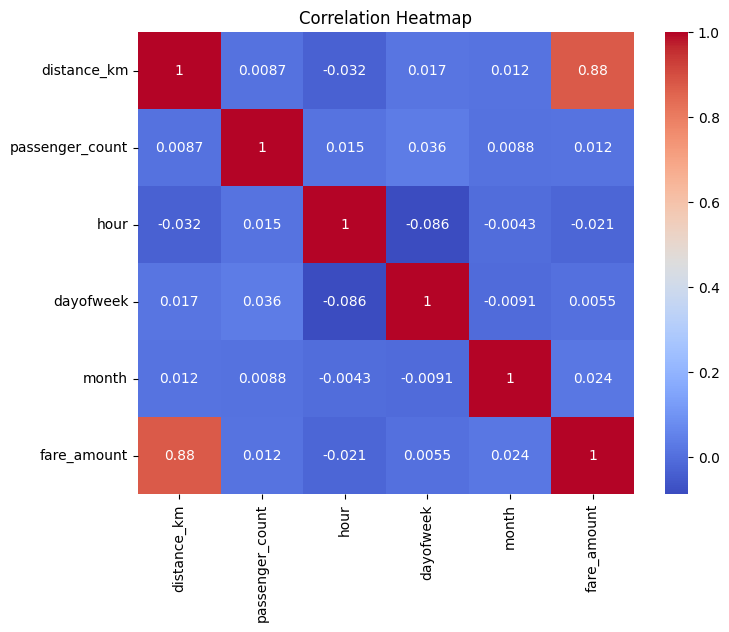

In [23]:

# -----------------------------
# 5. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df[features + ['fare_amount']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [24]:

# -----------------------------
# 6. Train-Test Split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [25]:

# -----------------------------
# 7. Linear Regression Model
# -----------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)


In [26]:

# -----------------------------
# 8. Random Forest Model
# -----------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)


In [30]:

# -----------------------------
# 9. Evaluation Function
# -----------------------------
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, )
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name}:\n  R2 = {r2:.3f}\n  RMSE = {rmse:.3f}\n  MAE = {mae:.3f}\n")

print("=== Model Evaluation ===")
evaluate(y_test, pred_lr, "Linear Regression")
evaluate(y_test, pred_rf, "Random Forest")


=== Model Evaluation ===
Linear Regression:
  R2 = 0.780
  RMSE = 20.006
  MAE = 2.314

Random Forest:
  R2 = 0.778
  RMSE = 20.160
  MAE = 2.409



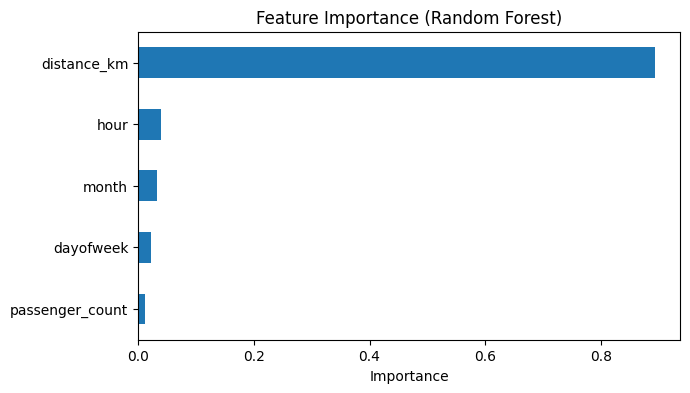

In [27]:

# -----------------------------
# 10. Feature Importance (RF)
# -----------------------------
feat_imp = pd.Series(rf.feature_importances_, index=features).sort_values()
plt.figure(figsize=(7,4))
feat_imp.plot(kind='barh', title='Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.show()